In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from utils import calc_performance, plot_confusion_matrix, calc_test_train_performance
import os
import sklearn.preprocessing as prep 

In [3]:
path = os.getcwd()

In [4]:
raw_df = pd.read_csv('../data/processed/completeddata.csv',index_col=0)

In [5]:
# scale the data to mean 0 sd 1
raw_df.iloc[:,2:-1] = prep.scale(raw_df.iloc[:,2:-1], axis = 0, with_mean = True, with_std = True)

In [6]:
# seperate the data to training & testing sets
train = raw_df[raw_df.Year <= 2016]
test = raw_df[raw_df.Year > 2016]

In [7]:
FEAT_SET = ['ValueOfProduction', 'MaximumColonies',
            'LostColonies', 'AddedColonies', 'Pesticides', 'OtherDiseases',
            'UnknownDiseases', 'Tavg', 'Prcp', 'Awnd']
TARGET = 'YieldClass'

In [8]:
X_train = train[FEAT_SET]
y_train = train[TARGET]

X_test = test[FEAT_SET]
y_test = test[TARGET]

## (1) Find the best solver and penalty type 
#### while keeping C constant

In [9]:
param_grid = [{'solver': ['saga'], 'penalty': ['l1']}, 
              {'solver': ('newton-cg', 'sag', 'lbfgs'), 'penalty': ['l2']}
             ]

estimator = LogisticRegression(multi_class='multinomial')

grid = GridSearchCV(estimator, param_grid = param_grid, 
                    scoring='accuracy', cv=5, verbose=1, refit=True)

grid.fit(X_train,y_train)

model = grid.best_estimator_

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.0s finished


### Best Params

In [10]:
print(grid.best_params_)

{'penalty': 'l2', 'solver': 'newton-cg'}


### Best Score

In [11]:
grid.best_score_

0.4634146341463415

## 2.1 Parameter Tuning 
#### Now knowing that newton-cg is the best solver with penalty l2, we tune C

In [12]:
# grid search
param_grid = {'C':np.logspace(-2,2)}
estimator = LogisticRegression(solver = 'newton-cg', penalty = 'l2', multi_class='multinomial')

grid = GridSearchCV(estimator, param_grid = param_grid, 
                    scoring='accuracy', cv=5, verbose=1, refit=True)

# fit to model
grid.fit(X_train,y_train)

# find the best model
model = grid.best_estimator_

# compare the result
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)



Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    5.4s finished


### Best Params

In [13]:
grid.best_params_

{'C': 47.1486636345739}

### Best Score

In [14]:
grid.best_score_

0.4878048780487805

### Model Performance:
#### The best model is not good enough. 
- Need to continue tunning with regularization constraint C. 

In [15]:
calc_test_train_performance(model, X_train, X_test, y_train, y_test)

,Train_Score,Test_Score
cross_entropy,0.816021,1.925465
accuracy,0.658537,0.341463


## 2.2 Continue Tuning C

In [21]:
param_grid = {'C':np.logspace(-5,5)}
estimator = LogisticRegression(solver = 'newton-cg', penalty = 'l2', multi_class='multinomial')

grid = GridSearchCV(estimator, 
                    param_grid = param_grid, scoring='accuracy', 
                    cv=5, verbose=1, refit=True)

grid.fit(X_train,y_train)

model = grid.best_estimator_

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    6.8s finished


### Best Params 

In [22]:
grid.best_params_

{'C': 54.286754393238596}

### Best Score

In [23]:
grid.best_score_

0.4878048780487805

### Model Performance 

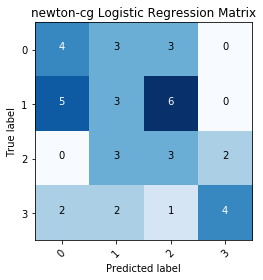

In [24]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=[0,1,2,3], title='newton-cg Logistic Regression Matrix')

In [25]:
calc_test_train_performance(model, X_train, X_test, y_train, y_test)

,Train_Score,Test_Score
cross_entropy,0.811810,1.941005
accuracy,0.658537,0.341463
